In [17]:
import sys
sys.path.append("/home/cyprien/Documents/github/pytorch-forecasting")

import hashlib

import numpy as np
from tqdm import tqdm

from data_factory.preprocessing import *
from utilities.config import load_config

logging.basicConfig(level=DEBUG)
logger = logging.getLogger(__name__)
logger.setLevel(DEBUG)

In [18]:
config_file = '../config/config.yml'
use_previous_files = False
export = False

In [19]:


config = load_config(config_file)

model = config['model']
model_config = config[model]

# Create variables from config
#  data loading
save_folder = config['data']['save']
train_file = config['data']['train_path'] + config['data']['stock_prices']
test_file = config['data']['test_path'] + config['data']['stock_prices']
#  TimeSeries settings
max_prediction_length = model_config['sliding_window']['max_prediction_length']
min_prediction_length = model_config['sliding_window']['min_prediction_length']
max_encoder_length = model_config['sliding_window']['max_encoder_length']
min_encoder_length = model_config['sliding_window']['min_encoder_length']
batch_size = model_config['sliding_window']['batch_size']

related_stocks = model_config['related_stock']
train_val_split = model_config['train_val_split']
scale = model_config['manual_scale']

# define file name for saving StockPricesLoader with specific config
hash_ = hashlib.md5(model_config.__str__().encode('utf-8')).hexdigest()
export_file_name = f"{save_folder}/export_{hash_}.p"
logger.debug(f'Export file {export_file_name}')

logger.debug(f'Use config {config}')


DEBUG:__main__:Export file ../data/save//export_90bb2aa697d08b219a986741dffc15e4.p
DEBUG:__main__:Use config {'device': 'cpu', 'seed': False, 'model': 'temporal_fusion_transformer', 'data': {'save': '../data/save/', 'suppl': '../data/suppl/', 'train_path': '../data/jpx-tokyo-stock-exchange-prediction/train_files/', 'test_path': '../data/jpx-tokyo-stock-exchange-prediction/supplemental_files/', 'financials': 'financials.csv', 'stock_prices': 'stock_prices.csv', 'options': 'options.csv', 'secondary_stock_price': 'secondary_stock_price.csv', 'trades': 'trades.csv', 'cosine': 'cosine_df.csv'}, 'rnn': {'sliding_window': {'max_prediction_length': 10, 'min_prediction_length': 10, 'max_encoder_length': 150, 'min_encoder_length': 150, 'batch_size': 64}, 'train_val_split': 1, 'related_stock': 2, 'manual_scale': True, 'hidden_size': 20, 'layers': 3, 'dropout': 0}, 'temporal_fusion_transformer': {'sliding_window': {'max_prediction_length': 10, 'min_prediction_length': 10, 'max_encoder_length': 150

### Load

In [20]:
df_train_raw = pd.read_csv(train_file, parse_dates=['Date'])
logger.info(f'{train_file} loaded. shape {df_train_raw.shape}')

df_test_raw = pd.read_csv(test_file, parse_dates=['Date'])
logger.info(f'{test_file} loaded. shape {df_test_raw.shape}')

for df in [df_test_raw, df_train_raw]:
    df['Timestamp'] = date_to_timestamp['1d'](df.Date.values.astype(np.int64)).astype(int)
    df.SupervisionFlag = df.SupervisionFlag.astype('category')
    df.SecuritiesCode = df.SecuritiesCode.astype(str)

INFO:__main__:../data/jpx-tokyo-stock-exchange-prediction/train_files/stock_prices.csv loaded. shape (2332531, 12)
INFO:__main__:../data/jpx-tokyo-stock-exchange-prediction/supplemental_files/stock_prices.csv loaded. shape (112000, 12)


### Preprocess

#### Fill na & Sort

In [21]:
# Fill na

df_train_raw.ExpectedDividend.fillna(value=0, inplace=True)
df_train_raw.loc[:, ['Open', 'High', 'Low', 'Close']] = df_train_raw.loc[:, ['Open', 'High', 'Low', 'Close']].fillna(method='ffill')

df_test_raw.ExpectedDividend.fillna(value=0, inplace=True)
df_test_raw.loc[:, ['Open', 'High', 'Low', 'Close']] = df_test_raw.loc[:, ['Open', 'High', 'Low', 'Close']].fillna(method='ffill')
logger.info(f'ExpectedDividend filled with 0. other values filled with ffill')

if df_train_raw.isna().sum(axis=0).any():
    logger.warning('na values in train dataset')
if df_test_raw.isna().sum(axis=0).any():
    logger.warning('na values in test dataset')

df_train_raw.sort_values(by=['SecuritiesCode', 'Timestamp'], inplace=True)
df_train_raw.reset_index(drop=True, inplace=True)
df_test_raw.sort_values(by=['SecuritiesCode', 'Timestamp'], inplace=True)
df_test_raw.reset_index(drop=True, inplace=True)

df_train, df_val = split_train_val_timeseries(df_train_raw, train_val_split=.95)
df_test = df_test_raw.copy()



INFO:__main__:ExpectedDividend filled with 0. other values filled with ffill


In [22]:
df_train_ppc, df_val_ppc, df_test_ppc = df_train.copy(), df_val.copy(), df_test.copy()

#### Fix adjusted price

In [23]:
tqdm.pandas()

cols_to_scale = ['Open', 'High', 'Low', 'Close']

def fix_adjusted_price(x):
    f = x[x.AdjustmentFactor != 1]
    for ts, adj_f, in zip(f.Timestamp, f.AdjustmentFactor):
        x.loc[(x.Timestamp <= ts), cols_to_scale] = x.loc[(x.Timestamp <= ts), cols_to_scale] * adj_f
    return x

df_train_ppc = df_train_ppc.groupby('SecuritiesCode').progress_apply(lambda x: fix_adjusted_price(x)).reset_index(drop=True)
df_val_ppc = df_val_ppc.groupby('SecuritiesCode').progress_apply(lambda x: fix_adjusted_price(x)).reset_index(drop=True)
df_test_ppc = df_test_ppc.groupby('SecuritiesCode').progress_apply(lambda x: fix_adjusted_price(x)).reset_index(drop=True)

logger.info(f'fix value with adjusted price done')

100%|██████████| 2000/2000 [00:01<00:00, 1691.95it/s]
INFO:__main__:fix value with adjusted price done


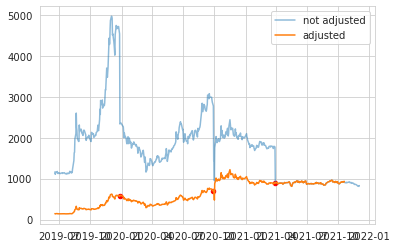

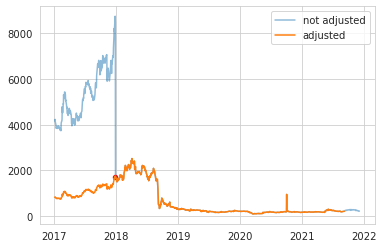

In [24]:
import matplotlib.pyplot as plt

f = df_train_ppc[df_train_ppc.AdjustmentFactor != 1]

for sc in f.SecuritiesCode.unique()[2:4]:
    plt.plot(df_train_raw[df_train_raw.SecuritiesCode == sc].Date, df_train_raw[df_train_raw.SecuritiesCode == sc].Close,
             alpha=.5, label='not adjusted')
    plt.plot(df_train_ppc[df_train_ppc.SecuritiesCode == sc].Date, df_train_ppc[df_train_ppc.SecuritiesCode == sc].Close,
             label='adjusted')
    plt.scatter(df_train_ppc[(df_train_ppc.SecuritiesCode == sc) & (df_train_ppc.AdjustmentFactor != 1)].Date,
                df_train_ppc[(df_train_ppc.SecuritiesCode == sc) & (df_train_ppc.AdjustmentFactor != 1)].Close, s=20, c='r')
    plt.legend()
    plt.show()

#### Scale

In [25]:
cols_to_scale = ['Open', 'High', 'Low', 'Close', 'Volume']
scalers = {}

def scale_col(col):
    scalers[col] = train_scalers_on_timeseries(df_train, col=col)
    scale_timeseries(df_train_ppc, scalers=scalers[col], col=col)
    scale_timeseries(df_val_ppc, scalers=scalers[col], col=col)
    scale_timeseries(df_test_ppc, scalers=scalers[col], col=col)

for col in cols_to_scale:
    scale_col(col)


#### Fill missing dates

In [26]:
df_train_ppc = fill_missing_dates(
    df_train_ppc, date_col='Date', timestamp_col='Timestamp', grp_col='SecuritiesCode', freq='1d',
    fill_with_value={'ExpectedDividend': 0}
)

df_val_ppc = fill_missing_dates(
    df_val_ppc, date_col='Date', timestamp_col='Timestamp', grp_col='SecuritiesCode', freq='1d',
    fill_with_value={'ExpectedDividend': 0}
)

df_test_ppc = fill_missing_dates(
    df_test_ppc, date_col='Date', timestamp_col='Timestamp', grp_col='SecuritiesCode', freq='1d',
    fill_with_value={'ExpectedDividend': 0}
)

DEBUG:data_factory.preprocessing:Fill grp 1301. shape: (1142, 19)
DEBUG:data_factory.preprocessing:Fill grp 1301 Done. shape: (1707, 18)
DEBUG:data_factory.preprocessing:Fill grp 1332. shape: (1142, 19)
DEBUG:data_factory.preprocessing:Fill grp 1332 Done. shape: (1707, 18)
DEBUG:data_factory.preprocessing:Fill grp 1333. shape: (1142, 19)
DEBUG:data_factory.preprocessing:Fill grp 1333 Done. shape: (1707, 18)
DEBUG:data_factory.preprocessing:Fill grp 1375. shape: (282, 19)
DEBUG:data_factory.preprocessing:Fill grp 1375 Done. shape: (421, 18)
DEBUG:data_factory.preprocessing:Fill grp 1376. shape: (1142, 19)
DEBUG:data_factory.preprocessing:Fill grp 1376 Done. shape: (1707, 18)
DEBUG:data_factory.preprocessing:Fill grp 1377. shape: (1142, 19)
DEBUG:data_factory.preprocessing:Fill grp 1377 Done. shape: (1707, 18)
DEBUG:data_factory.preprocessing:Fill grp 1379. shape: (1142, 19)
DEBUG:data_factory.preprocessing:Fill grp 1379 Done. shape: (1707, 18)
DEBUG:data_factory.preprocessing:Fill grp 1

#### Add previous timestamps to test set

##### Add history to val and test dataset so that they have material to work with when predicting

In [59]:
df_test_ppc['is_testing'] = True
df_train_ppc['is_testing'] = False
df_val_ppc['is_testing'] = False

df_test_ppc['is_val'] = False
df_train_ppc['is_val'] = False
df_val_ppc['is_val'] = True


#  Add previous dates to make use of them in the prediction
complement_start_point_ts = df_val_ppc.groupby('SecuritiesCode').Timestamp.min() - max_encoder_length
df_val_ppc_ext = pd.concat([
    df_train_ppc.groupby('SecuritiesCode').apply(lambda x: x.loc[(x.Timestamp >= complement_start_point_ts[x.name])]).reset_index(drop=True),
    df_val_ppc
]).sort_values(by=['SecuritiesCode', 'Timestamp']).reset_index(drop=True)


#  Add previous dates to make use of them in the prediction
complement_start_point_ts = df_test_ppc.groupby('SecuritiesCode').Timestamp.min() - max_encoder_length
df_test_ppc_ext = pd.concat([
    df_val_ppc_ext.groupby('SecuritiesCode').apply(lambda x: x.loc[(x.Timestamp >= complement_start_point_ts[x.name])]).reset_index(drop=True),
    df_test_ppc]
).sort_values(by=['SecuritiesCode', 'Timestamp']).reset_index(drop=True)

In [60]:
#  Fill missing dates in test dataframe so that the behaviour of TimeSeriesDataSet is always the same.
df_test_ppc_ext = fill_missing_dates(
    df_test_ppc_ext, 'Date', 'Timestamp', 'SecuritiesCode', '1d',
    fill_with_value={'ExpectedDividend': 0, 'is_testing': False}
)

#  Fill missing dates in val dataframe so that the behaviour of TimeSeriesDataSet is always the same.
df_val_ppc_ext = fill_missing_dates(
    df_val_ppc_ext, 'Date', 'Timestamp', 'SecuritiesCode', '1d',
    fill_with_value={'ExpectedDividend': 0, 'is_val': False}
)

DEBUG:data_factory.preprocessing:Fill grp 1301. shape: (233, 21)
DEBUG:data_factory.preprocessing:Fill grp 1301 Done. shape: (235, 20)
DEBUG:data_factory.preprocessing:Fill grp 1332. shape: (233, 21)
DEBUG:data_factory.preprocessing:Fill grp 1332 Done. shape: (235, 20)
DEBUG:data_factory.preprocessing:Fill grp 1333. shape: (233, 21)
DEBUG:data_factory.preprocessing:Fill grp 1333 Done. shape: (235, 20)
DEBUG:data_factory.preprocessing:Fill grp 1375. shape: (233, 21)
DEBUG:data_factory.preprocessing:Fill grp 1375 Done. shape: (235, 20)
DEBUG:data_factory.preprocessing:Fill grp 1376. shape: (233, 21)
DEBUG:data_factory.preprocessing:Fill grp 1376 Done. shape: (235, 20)
DEBUG:data_factory.preprocessing:Fill grp 1377. shape: (233, 21)
DEBUG:data_factory.preprocessing:Fill grp 1377 Done. shape: (235, 20)
DEBUG:data_factory.preprocessing:Fill grp 1379. shape: (233, 21)
DEBUG:data_factory.preprocessing:Fill grp 1379 Done. shape: (235, 20)
DEBUG:data_factory.preprocessing:Fill grp 1381. shape: 

##### Extend days so that TimeSeriesDataSet iterate over the last actual item in test dataset.

In [61]:
df_test_ppc_ext = add_days(
    df_test_ppc_ext,
    days=max_prediction_length,
    grp_col='SecuritiesCode',
    timestamp_col='Timestamp',
    date_col='Date'
)

### Export

In [62]:
from data_factory.prepared_data import PreparedData

In [63]:
data = PreparedData(df_train_ppc, df_val_ppc_ext, df_test_ppc_ext, scalers)

In [64]:
data.export('../data/save/preprocessed_data.pkl')

#### Some checks

In [74]:
df_test_ppc_ext.shape[0], df_test_ppc.shape[0] + (2000*max_encoder_length) + (2000*max_prediction_length)

(490000, 490000)

In [69]:
df_val_ppc_ext.shape[0], df_val_ppc.shape[0] + (2000*max_encoder_length)

(470719, 470719)